In [127]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from thirdpary import fem_2d_rec

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [129]:
f_values = np.arange(-5000, 5000, 2)
np.savetxt('./f_constant.txt', f_values, fmt='%f')
print("Create f_constant.txt.")

Create f_constant.txt.


In [130]:
f_values = np.loadtxt('./f_constant.txt')
print(f"Loaded {len(f_values)} f values.")

Loaded 5000 f values.


In [131]:
def apply_boundary_conditions(f_matrix, g=0):
    f = f_matrix.copy()
    f[:, 0] = g  # 왼쪽 경계
    f[:, -1] = g  # 오른쪽 경계
    f[0, :] = g  # 아래쪽 경계
    f[-1, :] = g  # 위쪽 경계
    return f

In [132]:
# 256x256 크기의 f 행렬 생성 및 경계 값 0으로 설정
input_shape = (256, 256)
f_matrices = []
for f_value in f_values:
    f_matrix = np.full(input_shape, f_value)
    f_matrix_with_boundary = apply_boundary_conditions(f_matrix)
    f_matrices.append(f_matrix_with_boundary)

f_matrices = np.array(f_matrices)
print(f"{len(f_matrices)} f matrices with boundary conditions.")

5000 f matrices with boundary conditions.


In [133]:
f_matrices.shape

(5000, 256, 256)

In [134]:
f_matrices[3]

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       ...,
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       [    0., -4994., -4994., ..., -4994., -4994.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [135]:
class PoissonDataset(Dataset):
    def __init__(self, f_matrices):
        self.f_matrices = f_matrices

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_matrix = self.f_matrices[idx]
        f_tensor = torch.tensor(f_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return f_tensor

In [136]:
dataset = PoissonDataset(f_matrices)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [137]:
def create_boundary_mask(size):
    mask = torch.ones(size, dtype=torch.float32)
    mask[:, 0] = 0  # 왼쪽 경계
    mask[:, -1] = 0  # 오른쪽 경계
    mask[0, :] = 0  # 아래쪽 경계
    mask[-1, :] = 0  # 위쪽 경계
    return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W) 형태로 변환

# 경계 마스크 생성
boundary_mask = create_boundary_mask((256, 256)).to(device)

In [138]:
boundary_mask, 1-boundary_mask

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 1., 1.,  ..., 1., 1., 0.],
           [0., 1., 1.,  ..., 1., 1., 0.],
           ...,
           [0., 1., 1.,  ..., 1., 1., 0.],
           [0., 1., 1.,  ..., 1., 1., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           ...,
           [1., 0., 0.,  ..., 0., 0., 1.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0'))

In [139]:
def unsupervised_loss(u_pred, f, h, boundary_mask):
    laplacian_filter = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(u_pred.device) # (1, 1, H, W) 형태로 변환 / 마이너스 라플라시안 필터
    laplacian_u = torch.nn.functional.conv2d(u_pred, laplacian_filter, padding=1)

    # 내부 손실 계산 (경계를 제외한 부분)
    interior_loss = torch.sum(((f*h**2 - laplacian_u) ** 2) * boundary_mask)

    # 경계 손실 계산 (경계에서의 값이 0이 되도록)
    boundary_loss = torch.sum(((u_pred)* (1 - boundary_mask)) ** 2)

    return interior_loss + boundary_loss

In [140]:
class Autoencoder(nn.Module):
    def __init__(self, rep_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, rep_dim),
            nn.ReLU()
        )

        # Latent space
        self.fc = nn.Linear(rep_dim, rep_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(rep_dim, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        latent = self.fc(encoded)
        u_pred = self.decoder(latent)
        return u_pred, latent

In [141]:
def mesh_fem_2d_rec(xl, xr, yl, yr, Mx, My, k):
    xx = np.linspace(xl, xr, k*Mx+1)
    yy = np.linspace(yl, yr, k*My+1)
    c4n = np.array([[x, y] for y in yy for x in xx])

    Nx = k*Mx+1
    Ny = k*My+1
    ind4e = np.array([[(j+k*m)*Nx+(i+k*n) for j in range(k+1) for i in range(k+1)] for m in range(My) for n in range(Mx)])
    n4e = ind4e[:, [0, k, (k+1)**2-1, k*(k+1)]]

    nNodes = Nx*Ny
    n4db = np.array([[[k*i+j for j in range(k+1)] for i in range(Mx)],
          [[k*Nx*(i) +k*Mx + j*Nx for j in range(k+1)] for i in range(My)],
          [[(nNodes - 1) - k*i - j for j in range(k+1)] for i in range(Mx)],
          [[Nx*(Ny-1) - k*Nx*i - j*Nx for j in range(k+1)] for i in range(My)]]).reshape(-1, k+1)
    return (c4n, n4e, n4db, ind4e)

def fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D):
    number_of_nodes = c4n.shape[0]
    number_of_elements = n4e.shape[0]
    b = np.zeros(number_of_nodes)
    u = np.zeros(number_of_nodes)
    xr = np.array([(c4n[n4e[i, 1], 0] - c4n[n4e[i, 0], 0]) / 2 for i in range(number_of_elements)])
    ys = np.array([(c4n[n4e[i, 3], 1] - c4n[n4e[i, 0], 1]) / 2 for i in range(number_of_elements)])
    J = xr * ys
    rx = ys / J
    sy = xr / J
    Aloc = np.array([J[i] * (rx[i]**2 * Srr_R.flatten() + sy[i]**2 * Sss_R.flatten()) for i in range(number_of_elements)])
    for i in range(number_of_elements):
        b[ind4e[i]] += J[i] * np.matmul(M_R, f(c4n[ind4e[i]]))
    row_ind = np.tile(ind4e.flatten(), ((k+1)**2, 1)).T.flatten()
    col_ind = np.tile(ind4e, (1, (k+1)**2)).flatten()
    A_COO = coo_matrix((Aloc.flatten(), (row_ind, col_ind)), shape=(number_of_nodes, number_of_nodes))
    A = A_COO.tocsr()
    dof = np.setdiff1d(range(0, number_of_nodes), np.unique(n4db))
    u[dof] = spsolve(A[dof, :].tocsc()[:, dof].tocsr(), b[dof])
    return u

def get_matrices_2d(k=1):
    r = np.linspace(-1, 1, k+1)
    V = VandermondeM1D(k, r)
    D_R_1d = Dmatrix1D(k, r, V)
    invV = np.linalg.solve(V, np.identity(k+1))

    M_R_1d = invV.T @ invV
    M_R = np.kron(M_R_1d, M_R_1d)

    Dr_R = np.kron(np.identity(k+1), D_R_1d)
    Ds_R = np.kron(D_R_1d, np.identity(k+1))

    Srr_R = Dr_R.T @ M_R @ Dr_R
    Sss_R = Ds_R.T @ M_R @ Ds_R
    return (M_R, Srr_R, Sss_R, Dr_R, Ds_R)

def nJacobiP(x, alpha=0, beta=0, degree=0):
    Pn = np.zeros((degree+1, x.size), float)
    Pn[0, :] = np.sqrt(2.0 ** (-alpha - beta - 1) \
                       * math.gamma(alpha + beta + 2) \
                       / ((math.gamma(alpha + 1) * math.gamma(beta + 1))))

    if degree == 0:
        P = Pn
    else:
        Pn[1, :] = np.multiply(Pn[0, :] * np.sqrt((alpha + beta + 3.0) \
            / ((alpha + 1) * (beta + 1))), ((alpha + beta + 2) * x + (alpha - beta))) / 2
        a_n = 2.0 / (2 + alpha + beta) * np.sqrt((alpha + 1.0) * (beta + 1.0) \
                                                / (alpha + beta + 3.0))
        for n in range(2, degree + 1):
            anew = 2.0 / (2 * n + alpha + beta) * np.sqrt(n * (n + alpha + beta) \
                                                          * (n + alpha) * (n + beta) \
                                                          / ((2 * n + alpha + beta - 1.0) * (2 * n + alpha + beta + 1.0)))
            b_n = -(alpha ** 2 - beta ** 2) \
                / ((2 * (n - 1) + alpha + beta) * (2 * (n - 1) + alpha + beta + 2.0))
            Pn[n, :] = (np.multiply((x - b_n), Pn[n - 1, :]) - a_n * Pn[n - 2, :]) \
                       / anew
            a_n = anew

    P = Pn[degree, :]
    return P

def VandermondeM1D(degree, r):
    V1D = np.zeros((r.size, degree + 1), float)
    for j in range(0, degree + 1):
        V1D[:, j] = nJacobiP(r, 0, 0, j)
    return V1D

def DnJacobiP(x, alpha=0, beta=0, degree=0):
    dP = np.zeros(x.size, float)
    if degree == 0:
        dP[:] = 0
    else:
        dP[:] = np.sqrt(degree * (degree + alpha + beta + 1.0)) \
                * nJacobiP(x, alpha + 1, beta + 1, degree - 1)
    return dP

def Dmatrix1D(degree, r, V):
    Vr = DVandermondeM1D(degree, r)
    Dr = np.linalg.solve(np.transpose(V), np.transpose(Vr))
    Dr = np.transpose(Dr)
    return Dr

def DVandermondeM1D(degree, r):
    DVr = np.zeros((r.size, degree + 1), float)
    for j in range(0, degree + 1):
        DVr[:, j] = DnJacobiP(r, 0, 0, j)
    return DVr

In [142]:
a = 0
b = 1
k = 1
M = 255
h = 1 / M
f = lambda c: np.full(c.shape[0], 2)
u_D = lambda c: np.zeros(c.shape[0])

c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)

fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
fem_u_reshaped = fem_u.reshape((256, 256))

In [143]:
# 모델 초기화
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 모델을 GPU로 이동
model = model.to(device)

# 경계 마스크 생성
boundary_mask = create_boundary_mask((256, 256)).to(device)

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        u_pred, _ = model(inputs)
        loss = unsupervised_loss(u_pred, inputs, h, boundary_mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# 모델 저장
torch.save(model.state_dict(), 'autoencoder_model.pth')
print("Model saved to autoencoder_model.pth")


Epoch [1/100], Loss: 72269.5004
Epoch [2/100], Loss: 10822.3001
Epoch [3/100], Loss: 9649.3222
Epoch [4/100], Loss: 8668.8061
Epoch [5/100], Loss: 7820.0318
Epoch [6/100], Loss: 7067.1709
Epoch [7/100], Loss: 6376.1094
Epoch [8/100], Loss: 5676.5584
Epoch [9/100], Loss: 5210.4588
Epoch [10/100], Loss: 4933.9962
Epoch [11/100], Loss: 4738.4743
Epoch [12/100], Loss: 4493.4375
Epoch [13/100], Loss: 4473.4778
Epoch [14/100], Loss: 4359.8361
Epoch [15/100], Loss: 4283.5211
Epoch [16/100], Loss: 4258.7524
Epoch [17/100], Loss: 4277.2225
Epoch [18/100], Loss: 4210.9849
Epoch [19/100], Loss: 4196.6730
Epoch [20/100], Loss: 4161.0805
Epoch [21/100], Loss: 4226.9614
Epoch [22/100], Loss: 4136.5694
Epoch [23/100], Loss: 4128.3806
Epoch [24/100], Loss: 4108.0009
Epoch [25/100], Loss: 4102.1497
Epoch [26/100], Loss: 4099.7406
Epoch [27/100], Loss: 4107.5364
Epoch [28/100], Loss: 4108.1948
Epoch [29/100], Loss: 4095.3274
Epoch [30/100], Loss: 4132.7714
Epoch [31/100], Loss: 4068.9672
Epoch [32/100],

In [144]:
# 모델 로드
model.load_state_dict(torch.load('autoencoder_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
    (11): ReLU()
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2)

In [146]:
f_tensor = torch.tensor(f_matrices[0]).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    predicted_u, _ = model(f_tensor)
    
predicted_u = predicted_u.squeeze().cpu().numpy()

In [147]:
# MSE 계산 및 시각화
mse = np.mean((predicted_u - fem_u_reshaped) ** 2)
print(f'Mean Squared Error: {mse}\n')
print(f'dl_u: \n{predicted_u}\n')
print(f'fem_u: \n{fem_u_reshaped}\n')

Mean Squared Error: 0.500432786004854

dl_u: 
[[0.04967197 0.01707991 0.02391988 ... 0.02120605 0.01636723 0.02995701]
 [0.02039165 0.0009082  0.00078521 ... 0.00073062 0.00066548 0.01866348]
 [0.01606615 0.00061115 0.00050324 ... 0.00065878 0.00100461 0.03021178]
 ...
 [0.02268694 0.00066091 0.00041489 ... 0.00031574 0.00067622 0.02574109]
 [0.02209414 0.0008191  0.00082662 ... 0.00081446 0.00092839 0.02933783]
 [0.04476889 0.00814616 0.01348527 ... 0.02673992 0.01916635 0.03050317]]

fem_u: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0001046  0.00019172 ... 0.00019172 0.0001046  0.        ]
 [0.         0.00019172 0.00036105 ... 0.00036105 0.00019172 0.        ]
 ...
 [0.         0.00019172 0.00036105 ... 0.00036105 0.00019172 0.        ]
 [0.         0.0001046  0.00019172 ... 0.00019172 0.0001046  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]



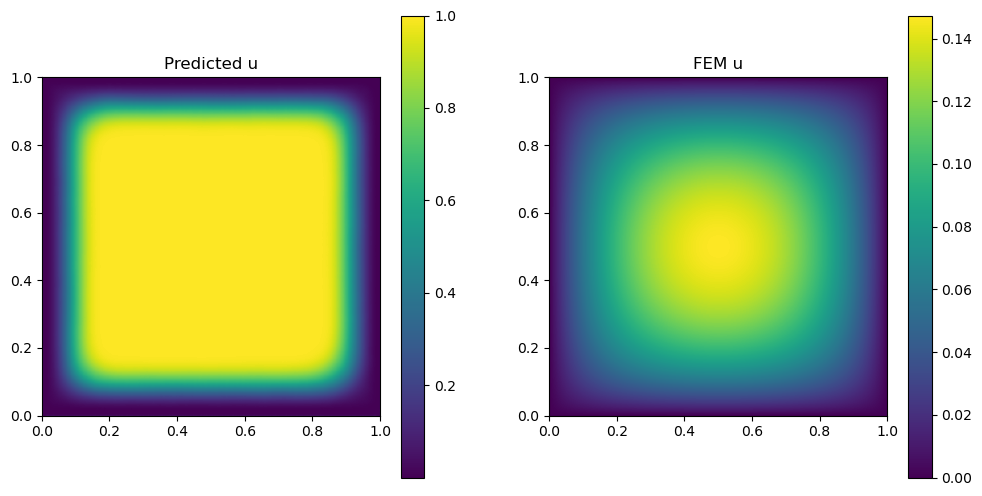

In [149]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Predicted u")
plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("FEM u")
plt.imshow(fem_u.reshape((256, 256)), cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()

plt.show()